In [391]:
import json
import pandas as pd
import sys
import numpy as np
import lhsmdu
import lhs
from pyDOE import *
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plot
import seaborn as sns
from pylab import rcParams

#the following is required to generate nice figures
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8


In [392]:
#read input file (this file shoule include indepedents variabels (e.g. gas price, demand, ... ) and output (zonal/nodal price)) 
df = pd.read_csv("input.csv")
df.head()

,Year,demand(TWh),demand(MW),LIG,SUB,Carbon Cost,Henry Hub,Waha,WTI,Gas CC,Gas CT,Gas ST,Coal,Onshore Wind,Solar PV,Average LMP ($/MWh)
0,2021,393.32,75219.67,9.69,12.14,0,3.06,2.59,58.82,34723.60,7257.9,11203.0,13493.5,24256.7,3568,44.263677
1,2022,397.44,76016.73,9.57,12.00,0,3.50,3.10,57.57,37928.50,7257.9,11203.0,10493.5,24256.7,4618,37.151517
2,2023,401.75,76858.83,9.76,12.17,0,3.50,3.10,66.47,41822.12,7257.9,11203.0,10493.5,24256.7,4918,39.837304
3,2024,407.22,77620.05,9.78,12.17,0,3.50,3.10,66.47,46082.01,7257.9,11203.0,10493.5,24256.7,5518,40.889910
4,2025,409.53,78272.14,9.80,12.19,0,3.50,3.10,66.47,50293.45,7257.9,11203.0,7969.5,24256.7,6418,40.182370


coefficient of determination: 0.971939047713371
intercept: 36.968597875164086
slope: [-4.52771342e-02  4.65267163e-03  3.04455346e+01 -4.19333893e+01
 -2.12291473e-01 -9.85462195e+00 -1.14224027e+01  5.98539805e-01
 -9.17280010e-04 -4.44010784e-03  4.24577164e-04 -7.47412926e-04
 -5.21439332e-04 -1.18485819e-03]


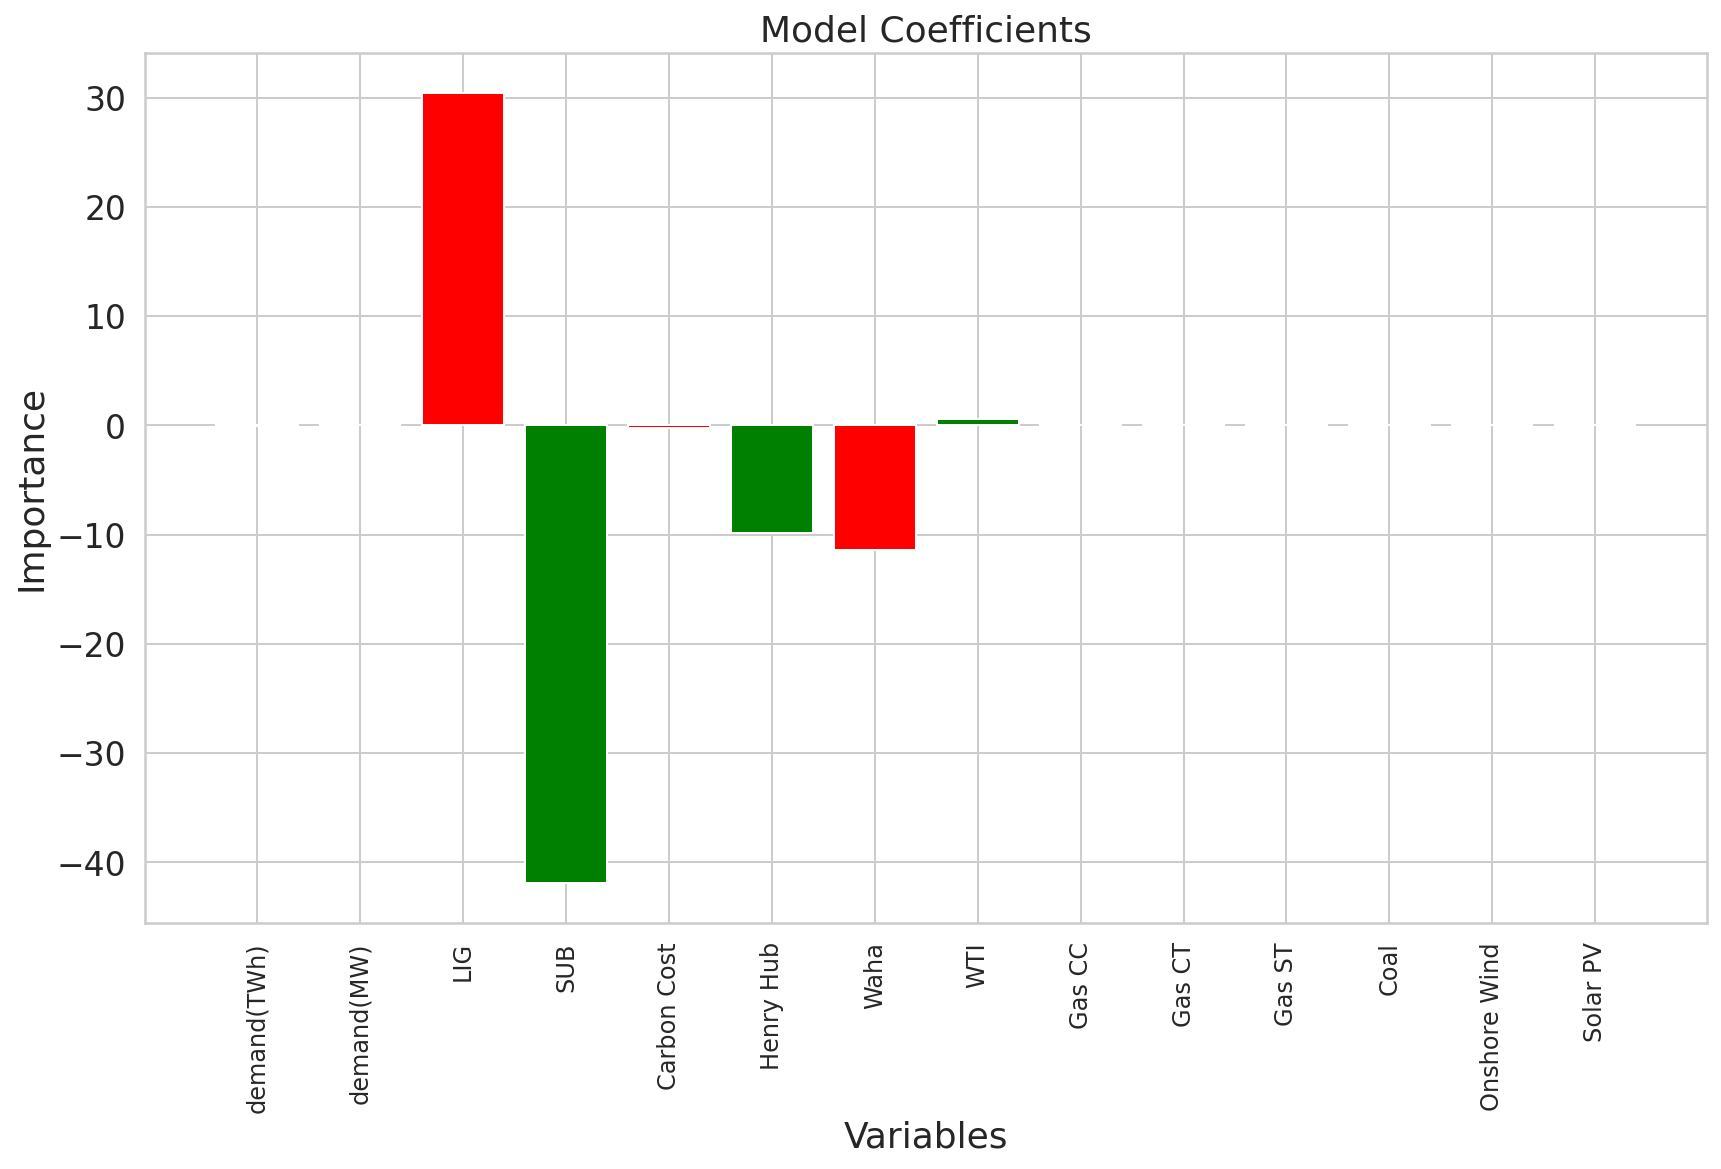

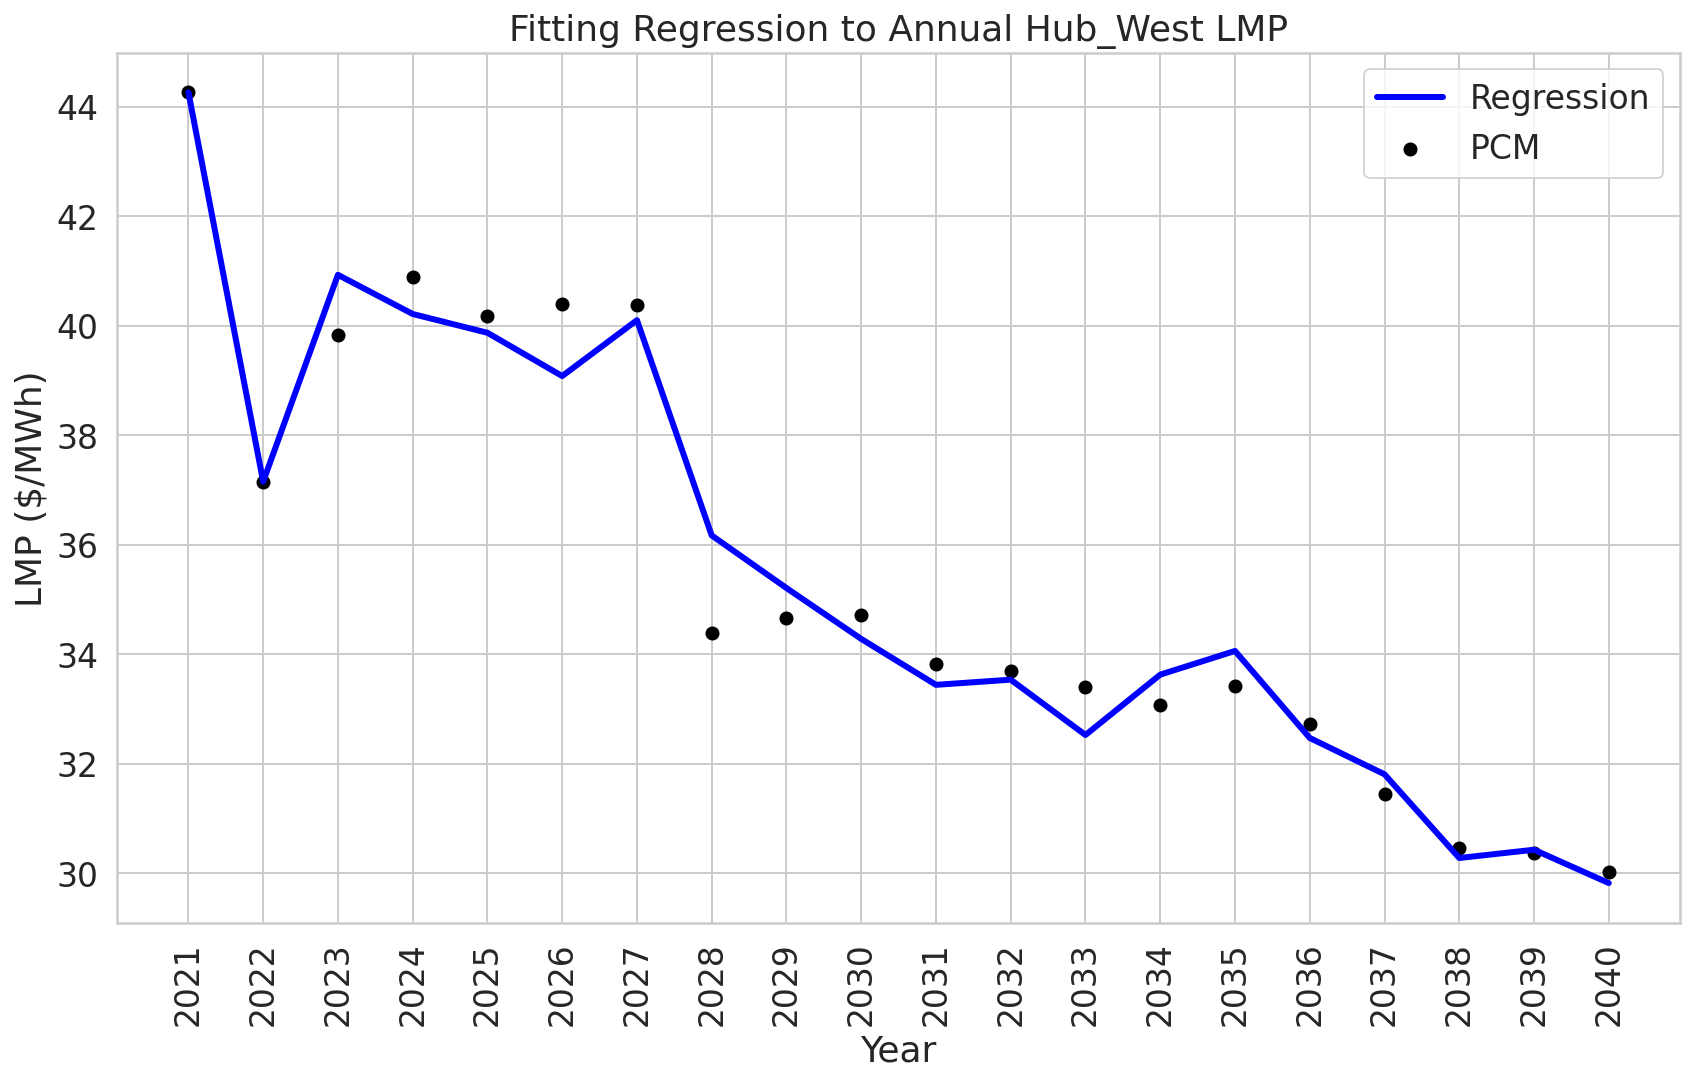

Text(0.5, 0, 'LMP ($/MWh)')

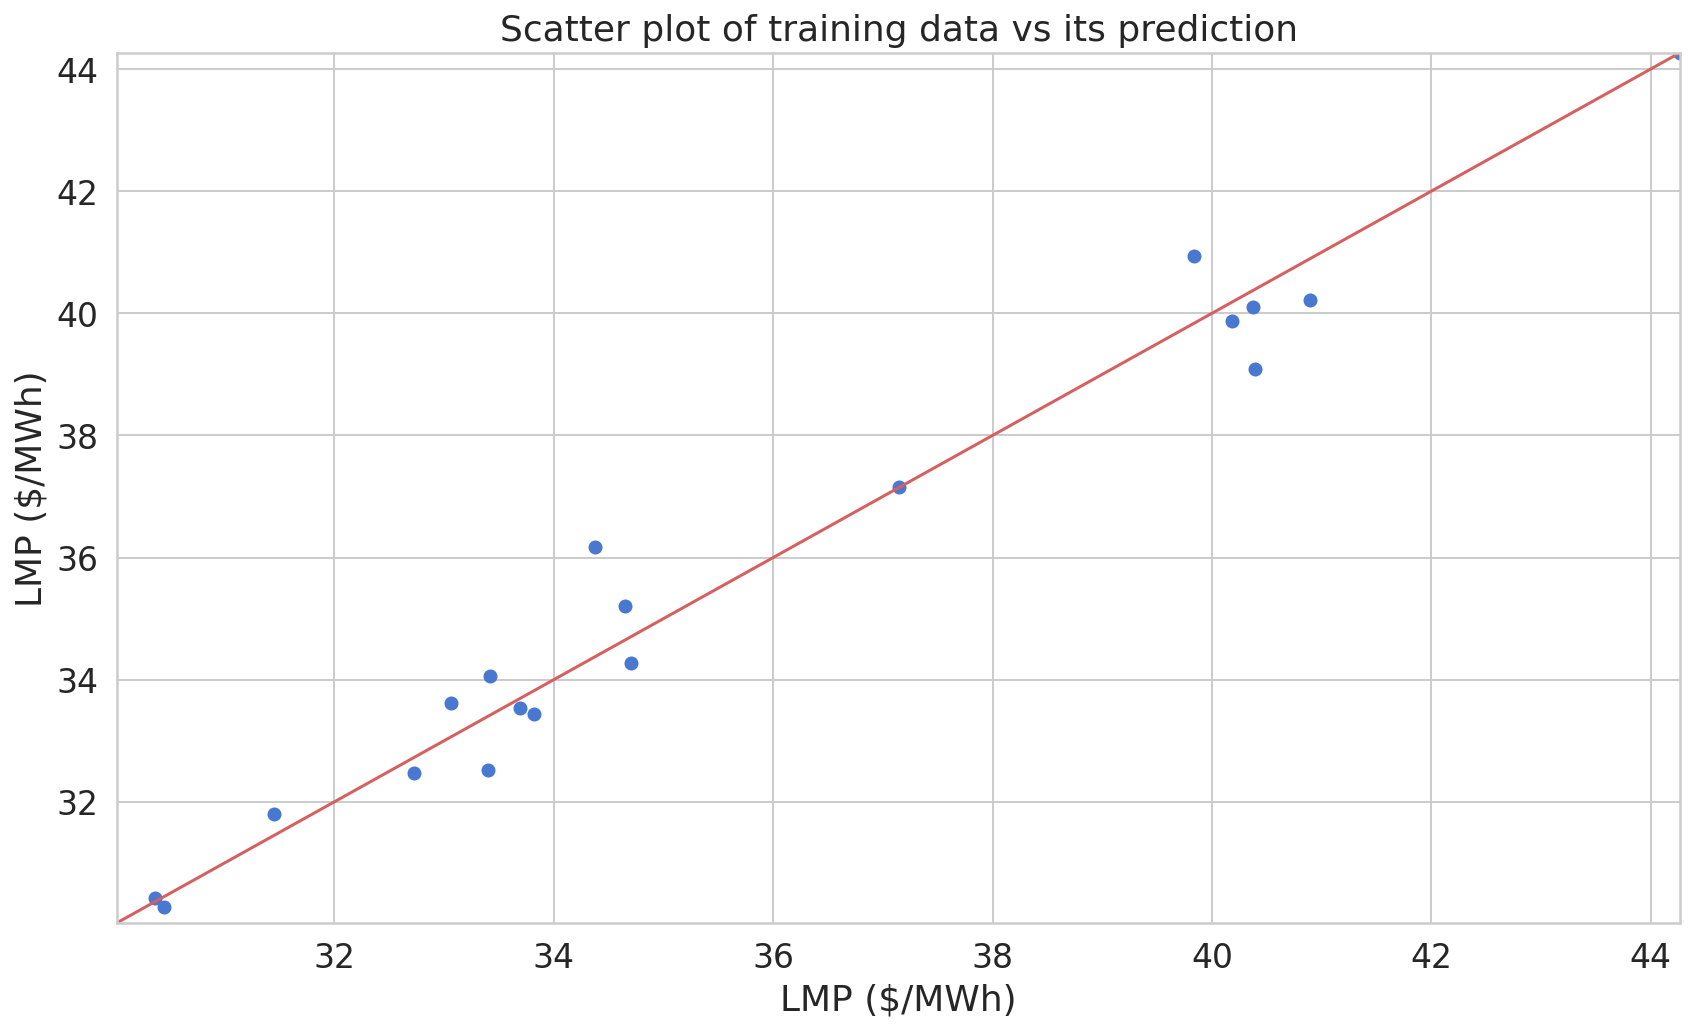

In [411]:
# fit a model to the data using regression

#select year column
year=df.iloc[:,0]

#select independent variables (e.g.gas price, demand, generation )
x=df.iloc[:,1:15]

#select dependent variable (output/price)
y=df.iloc[:,15]

#fit regression model
model = LinearRegression().fit(x, y)

#check r2
r_sq = model.score(x, y)
print('coefficient of determination:', r_sq)
print('intercept:', model.intercept_)
print('slope:', model.coef_)

#plot regression coeffiencets to show importance of the features/independent variables
# x-coordinates of left sides of bars  
left = list(range(1, 15))
 
# heights of bars fro the plot
height = model.coef_
  
# labels for bars 
tick_label = list(df.columns[1:15]) 
  
# plotting a bar chart 
plt.bar(left, height, tick_label = tick_label, 
        width = 0.8, color = ['red', 'green']) 
  
# naming the x-axis 
plt.xlabel('Variables') 
plt.xticks(fontsize=12 )
plt.xticks(rotation=90)
# naming the y-axis 
plt.ylabel('Importance') 
# plot title 
plt.title('Model Coefficients') 
# function to show the plot 
plt.show() 

#print prediction
y_pred = model.predict(x)
#print('predicted response:', y_pred, sep='\n')

ticks=list(range(2021, 2041))
# Plot outputs
plt.scatter(year,y,color='black',label="PCM")
plt.plot(year,y_pred,color='blue', linewidth=3,label="Regression")
lineStart = year.min() 
lineEnd   = year.max()  
ax = plt.gca() # grab the current axis
#plt.xticks(range(len(year)), [val[0] for val in year])
ax.set_xticks(ticks)
plt.xticks(rotation=90)
plt.ylabel('LMP ($/MWh)') 
plt.xlabel('Year')
plt.title('Fitting Regression to Annual Hub_West LMP') 
plt.legend(loc="upper right")
plt.show()


plt.scatter(y,y_pred)
lineStart = y.min() 
lineEnd   = y.max()
plt.plot([lineStart, lineEnd], [lineStart, lineEnd], 'k-', color = 'r')
plt.xlim([lineStart, lineEnd])
plt.ylim(lineStart, lineEnd)
title_text = "Scatter plot of training data vs its prediction"
plt.title(title_text)
plt.ylabel('LMP ($/MWh)') 
plt.xlabel('LMP ($/MWh)')



In [347]:
#now we will create the results based on the above
# gas=[0.5,1.5]
# demand=[0.8,1.2]
# wind=[0.9,1.1]
# solar=[0.9,1.1]
# coal=[0.9,1.1]
# carbon=[0.5,1.5]

#here is the steps:
#1- create samples for the above varibles, we have 15 
#design = lhsmdu.sample(10,15)
#2-scale the variables based on the min/max of them 
#3-convert them to the actual valeus for each year
#4-predict the LMP

# def scale_number(unscaled, to_min, to_max, from_min, from_max):
#     return (to_max-to_min)*(unscaled-from_min)/(from_max-from_min)+to_min

# def scale_list(l, to_min, to_max):
#     return [scale_number(i, to_min, to_max, min(l), max(l)) for i in l]

# scale_list([1,3,4,5], 0, 100)

#create a set of random numers for the one year
design = lhsmdu.sample(10000,14)
design_df = pd.DataFrame(design)
design_df.head()
#rename column name 
design_df.columns = list(df.columns[1:15]) 
design_df.head()

#scale them from [0,1] to the range that is specified for them, as an example [0.9,1.1] for test
scaler=MinMaxScaler(feature_range=(0.95,1.05))
design_df_scale=scaler.fit_transform(design_df)
design_scale_df = pd.DataFrame(design_df_scale)
design_scale_df.columns = list(df.columns[1:15]) 
design_scale_df.head()
# #design_df_scale['WTI_new'] = scaler.fit_transform(design_df['WTI'])


# scaler = MinMaxScaler()
# design_df['Col1_scaled'] = scaler.fit_transform(design_df['WTI'].values.reshape(0,1)*2)


# design_df.head()

#it is function for scaling each column other than 0.9-1.1
def remap(x, in_min, in_max, out_min, out_max):
    return (x - in_min) * (out_max - out_min) / (in_max - in_min) + out_min

design_scale_df['Henry Hub'] = remap(design_scale_df['Henry Hub'],0.95,1.05,0.95,1.05)
design_scale_df['Waha'] = remap(design_scale_df['Waha'],0.95,1.05,0.95,1.05)
design_scale_df['WTI'] = remap(design_scale_df['WTI'],0.95,1.05,0.95,1.05)
design_scale_df['demand(TWh)'] = remap(design_scale_df['demand(TWh)'],0.95,1.05,0.95,1.05)
design_scale_df['demand(MW)'] = remap(design_scale_df['demand(MW)'],0.95,1.05,0.95,1.05)
design_scale_df['Carbon Cost'] = remap(design_scale_df['Carbon Cost'],0.95,1.05,0.95,1.05)

design_scale_df.head()


,demand(TWh),demand(MW),LIG,SUB,Carbon Cost,Henry Hub,Waha,WTI,Gas CC,Gas CT,Gas ST,Coal,Onshore Wind,Solar PV
0,0.999526,0.986838,0.958528,0.974151,0.951589,1.024351,1.006787,1.030514,1.012169,1.048304,0.985437,1.015119,1.037921,0.971021
1,0.998291,1.029199,0.980004,0.955961,0.988474,1.039876,0.965878,1.011544,1.026811,0.973221,1.020062,0.960854,1.000975,1.049276
2,0.997827,1.022741,0.977932,1.013726,0.967989,1.016231,0.953228,0.984006,0.992540,1.006849,0.957499,1.042215,1.030615,1.043941
3,1.022129,1.047162,1.038038,0.994502,0.971038,0.981802,1.017989,1.004644,1.010390,0.955360,0.977982,0.992507,0.958188,1.028966
4,0.954876,0.960093,1.023673,1.032271,1.019627,0.975466,1.036913,1.009105,0.987161,0.983955,1.045179,0.971268,0.995141,1.004295


<Figure size 2880x2160 with 0 Axes>

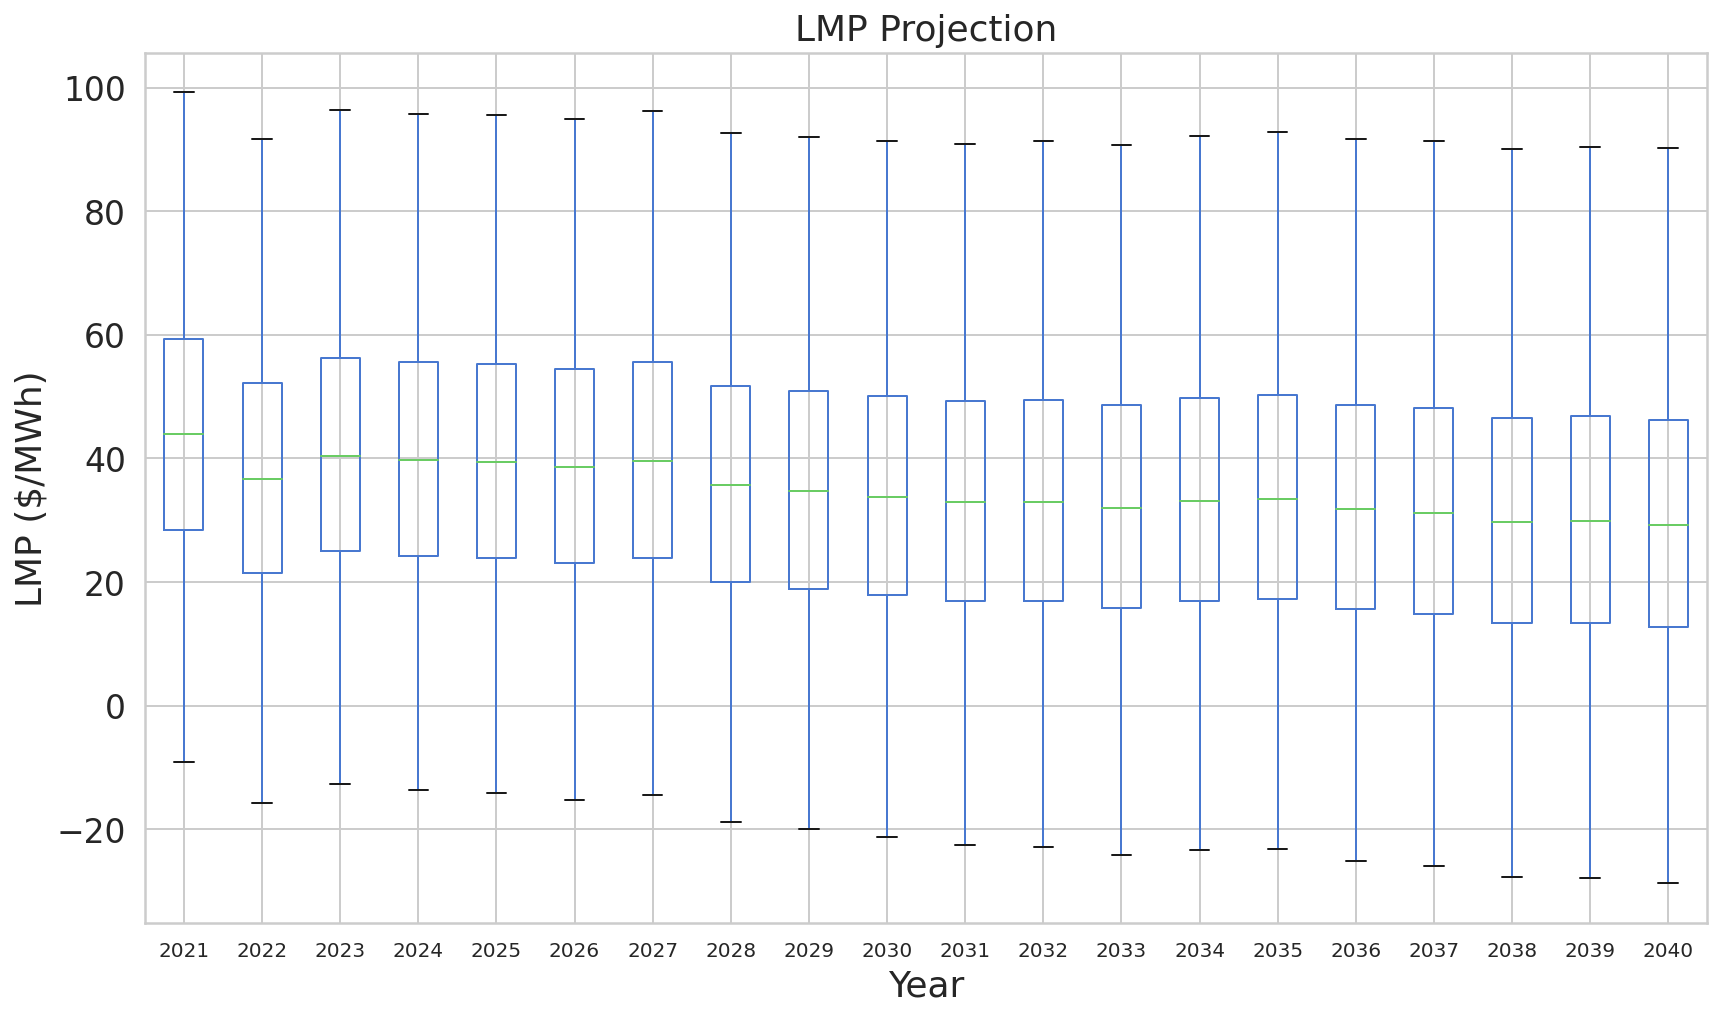

<Figure size 2880x2160 with 0 Axes>

In [361]:
reg_data = []
for i in range(20):
    #print(i)
    year= df.iloc[i,1:15].values
    #convert to real range
    new_x=design_scale_df*year
    y_pred = model.predict(new_x)
    reg_data.append(y_pred)
    
    

reg_data_df = pd.DataFrame(np.transpose(reg_data))
year=df.iloc[:,0]
reg_data_df.columns = year

reg_data_df.head()
#my_data = np.arange(10)
#print(df.iloc[0,1:15].values)

#plt.scatter(y_pred_new,my_data)

#multiplicationResults = design_scale_df.mul(year_one);

#multiplicationResults.head()

#design_scale_df.multiply(year_one, axis=0)

reg_data_df.plot(kind='box')

plt.title('LMP Projection')
plt.xlabel('Year')
plt.ylabel('LMP ($/MWh)')
plt.xticks(fontsize=10 )
plt.figure(figsize=(40,30))
 
# # Create names on the x axis
# x_pos = year;
# plt.xticks(x_pos)
 
# # Show graph
# plt.show()



In [221]:
lhs(4, samples=10)
#insert low and High limits for the inputs, for now we insert as percentage
gas=[-1.5,1.5]
demand=[-1.2,1.2]
wind=[-1.1,1.1]

from scipy.stats.distributions import norm
design = lhsmdu.sample(10,4)
print(design)
means = [1, 1, 1, 1]
stdvs = [1, 1, 1, 1]
#lhd = norm(loc=0, scale=1).ppf(design)

#for i in range(4):design[:, i] = norm(loc=means[i], scale=stdvs[i]).ppf(design[:, i])

#print(design)



[[0.79710373 0.46198032 0.65137569 0.11563963]
 [0.34948756 0.21109212 0.83058454 0.60489472]
 [0.0343506  0.53182041 0.4917331  0.89806737]
 [0.07259355 0.99136256 0.32567253 0.57998615]
 [0.45667857 0.76881454 0.69298057 0.00659809]
 [0.28947016 0.76658491 0.03080698 0.66723509]
 [0.30017617 0.24921514 0.88790631 0.64208156]
 [0.72873203 0.80064081 0.41913823 0.146185  ]
 [0.05088471 0.66887354 0.88704243 0.41760831]
 [0.42639319 0.5191557  0.77695046 0.17779114]]


[75219.67       75526.68906122 75833.70812245 76140.72718367
 76447.7462449  76754.76530612 77061.78436735 77368.80342857
 77675.8224898  77982.84155102 78289.86061224 78596.87967347
 78903.89873469 79210.91779592 79517.93685714 79824.95591837
 80131.97497959 80438.99404082 80746.01310204 81053.03216327
 81360.05122449 81667.07028571 81974.08934694 82281.10840816
 82588.12746939 82895.14653061 83202.16559184 83509.18465306
 83816.20371429 84123.22277551 84430.24183673 84737.26089796
 85044.27995918 85351.29902041 85658.31808163 85965.33714286
 86272.35620408 86579.37526531 86886.39432653 87193.41338776
 87500.43244898 87807.4515102  88114.47057143 88421.48963265
 88728.50869388 89035.5277551  89342.54681633 89649.56587755
 89956.58493878 90263.604     ]


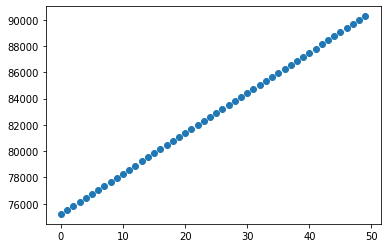

In [222]:
import matplotlib.pyplot as plt
M = 50
demand=75219.67
t = np.linspace(demand, 1.2*demand, M)
y=np.arange(0,50,1)
print(t)
plt.scatter(y,t)

In [ ]:
#now we will create the results based on the above
gas=[0.5,1.5]
demand=[0.8,1.2]
wind=[0.9,1.1]
solar=[0.9,1.1]
coal=[0.9,1.1]
carbon=[0.5,1.5]

#here is the steps:
#1- create samples for the above varibles, we have 15 
#design = lhsmdu.sample(10,15)
#2-scale the variables based on the min/max of them 
#3-convert them to the actual valeus for each year
#4-predict the LMP

def scale_number(unscaled, to_min, to_max, from_min, from_max):
    return (to_max-to_min)*(unscaled-from_min)/(from_max-from_min)+to_min

def scale_list(l, to_min, to_max):
    return [scale_number(i, to_min, to_max, min(l), max(l)) for i in l]

scale_list([1,3,4,5], 0, 100)

#create a set of random numers for the one year
design = lhsmdu.sample(10,14)
design_df = pd.DataFrame(design)
design_df.head()

#scale them from [0,1] to the range that is specified for them, as an example [0.9,1.1] for test
scaler=MinMaxScaler(feature_range=(0.9,1.1))
design_df_scale=scaler.fit_transform(design_df)
design_scale_df = pd.DataFrame(design_df_scale)
#design_scale_df.head()



#print(len(year))
#get the values of row one
reg_data = []
for i in range(14):
    #print(i)
    year= df.iloc[i,1:15].values
    #convert to real range
    new_x=design_scale_df*year
    y_pred = model.predict(new_x)
    reg_data.append(y_pred)

    
reg_data_df = pd.DataFrame(reg_data)

reg_data_df.head()
#my_data = np.arange(10)
#print(df.iloc[0,1:15].values)

#plt.scatter(y_pred_new,my_data)

#multiplicationResults = design_scale_df.mul(year_one);

#multiplicationResults.head()

#design_scale_df.multiply(year_one, axis=0)



# year_df=df.iloc[:,0]

# lineStart = year_df.min() 
# lineEnd   = year_df.max()  


# plt.xlim(lineStart, lineEnd)

# title_text = "Scatter plot of training data vs its prediction"
# plt.title(title_text)

/home/usmhhv/.local/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'LMP ($/MWh)')

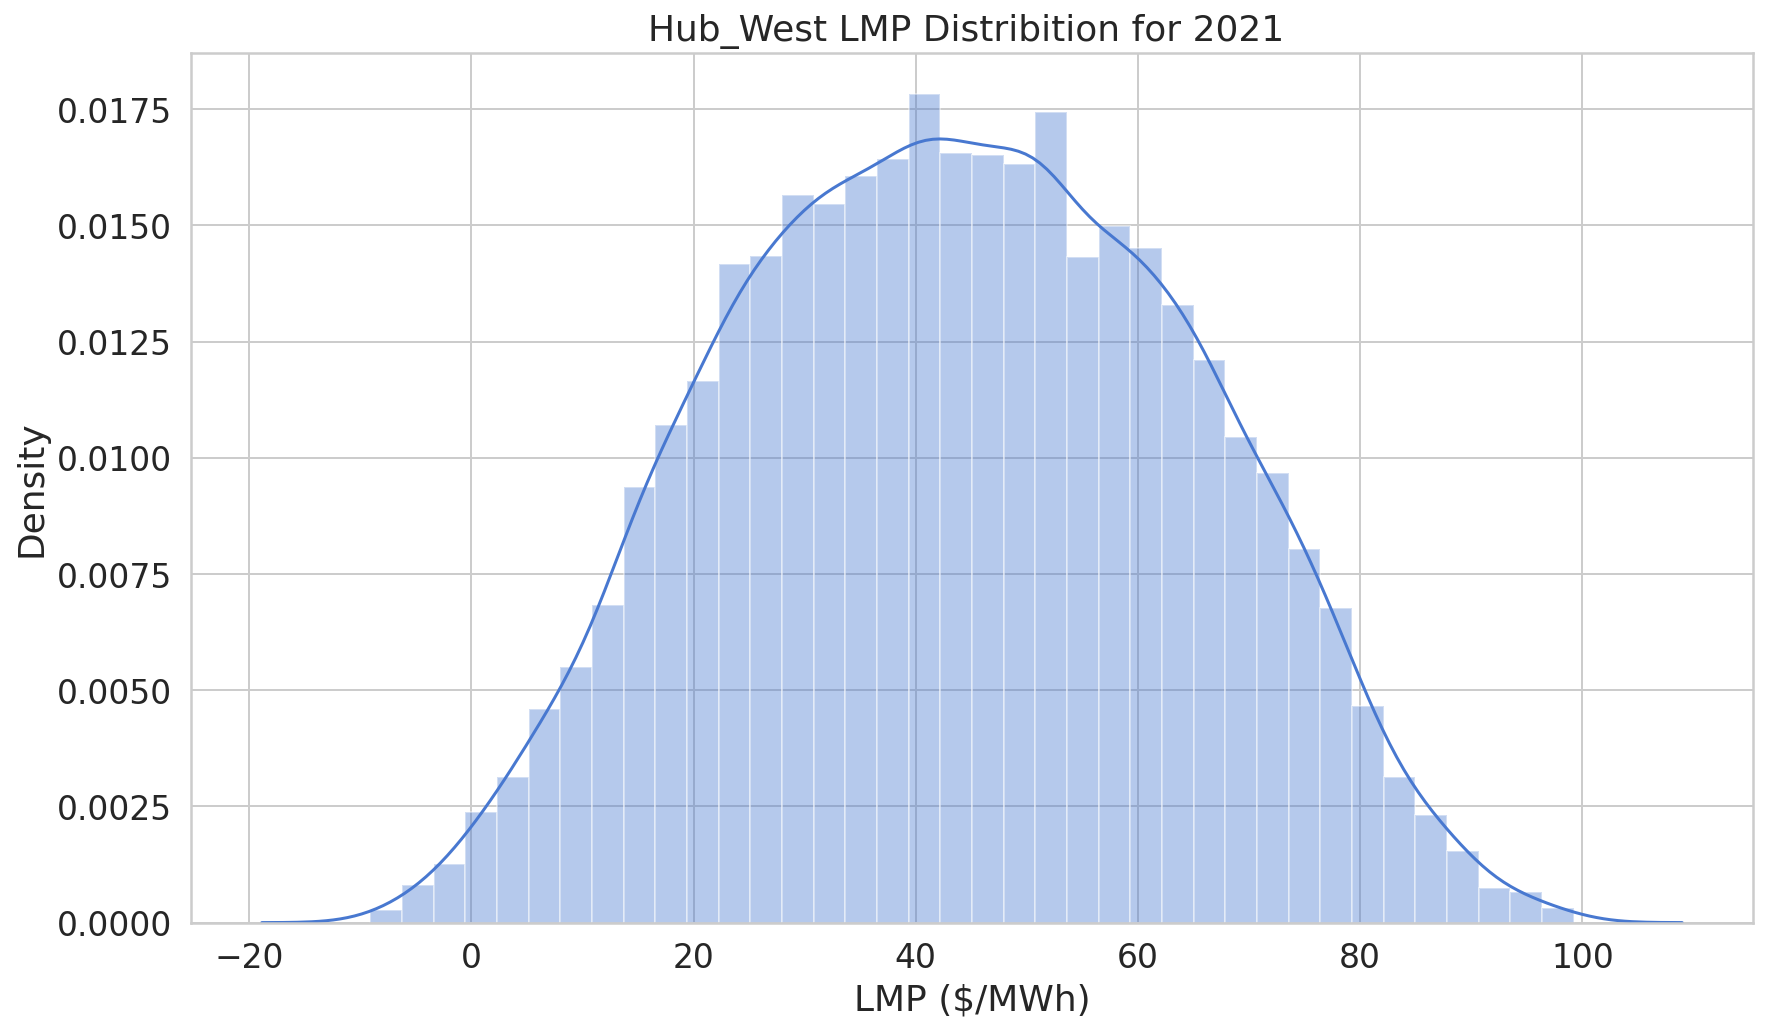

In [430]:
#plot histogram of the LMP for one year
sns.distplot(reg_data_df.iloc[:,0] )

reg_data_df.head()
plt.title('Hub_West LMP Distribition for 2021 ')
plt.xlabel('LMP ($/MWh)')



Text(0.5, 0, 'LMP ($/MWh)')

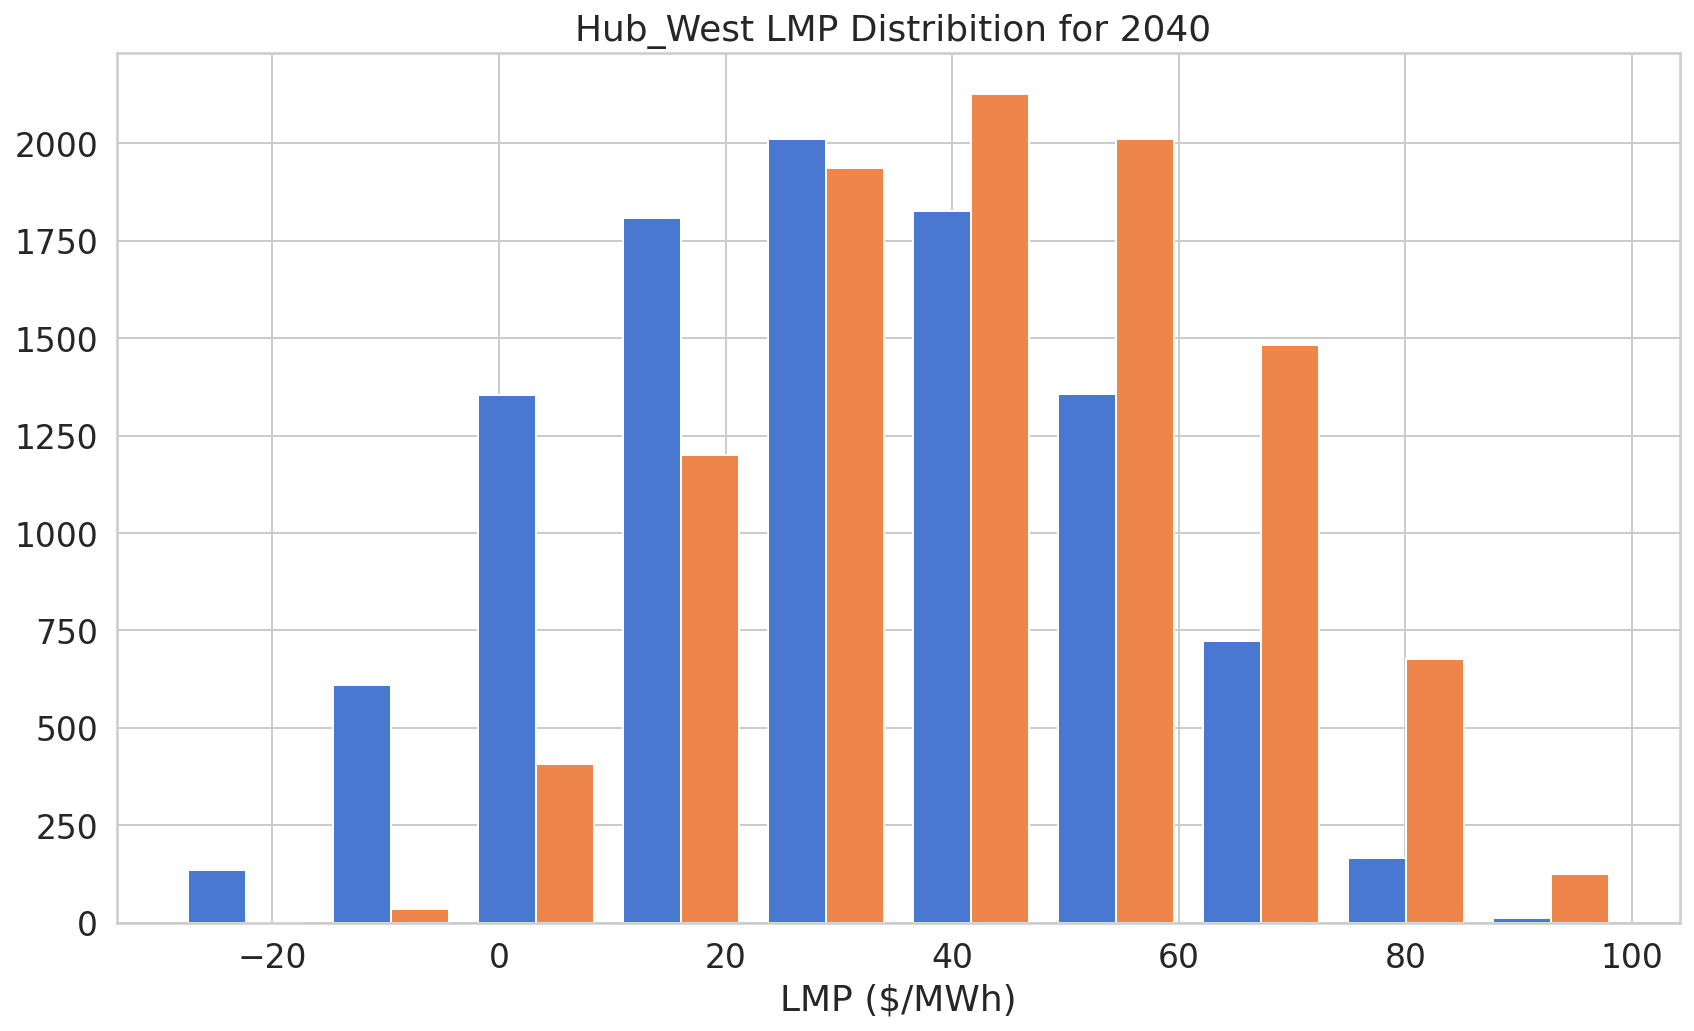

In [456]:
plt.hist([reg_data_df.iloc[:,19],reg_data_df.iloc[:,0]] )


reg_data_df.head()
plt.title('Hub_West LMP Distribition for 2040 ')
plt.xlabel('LMP ($/MWh)')

/home/usmhhv/.local/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/usmhhv/.local/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


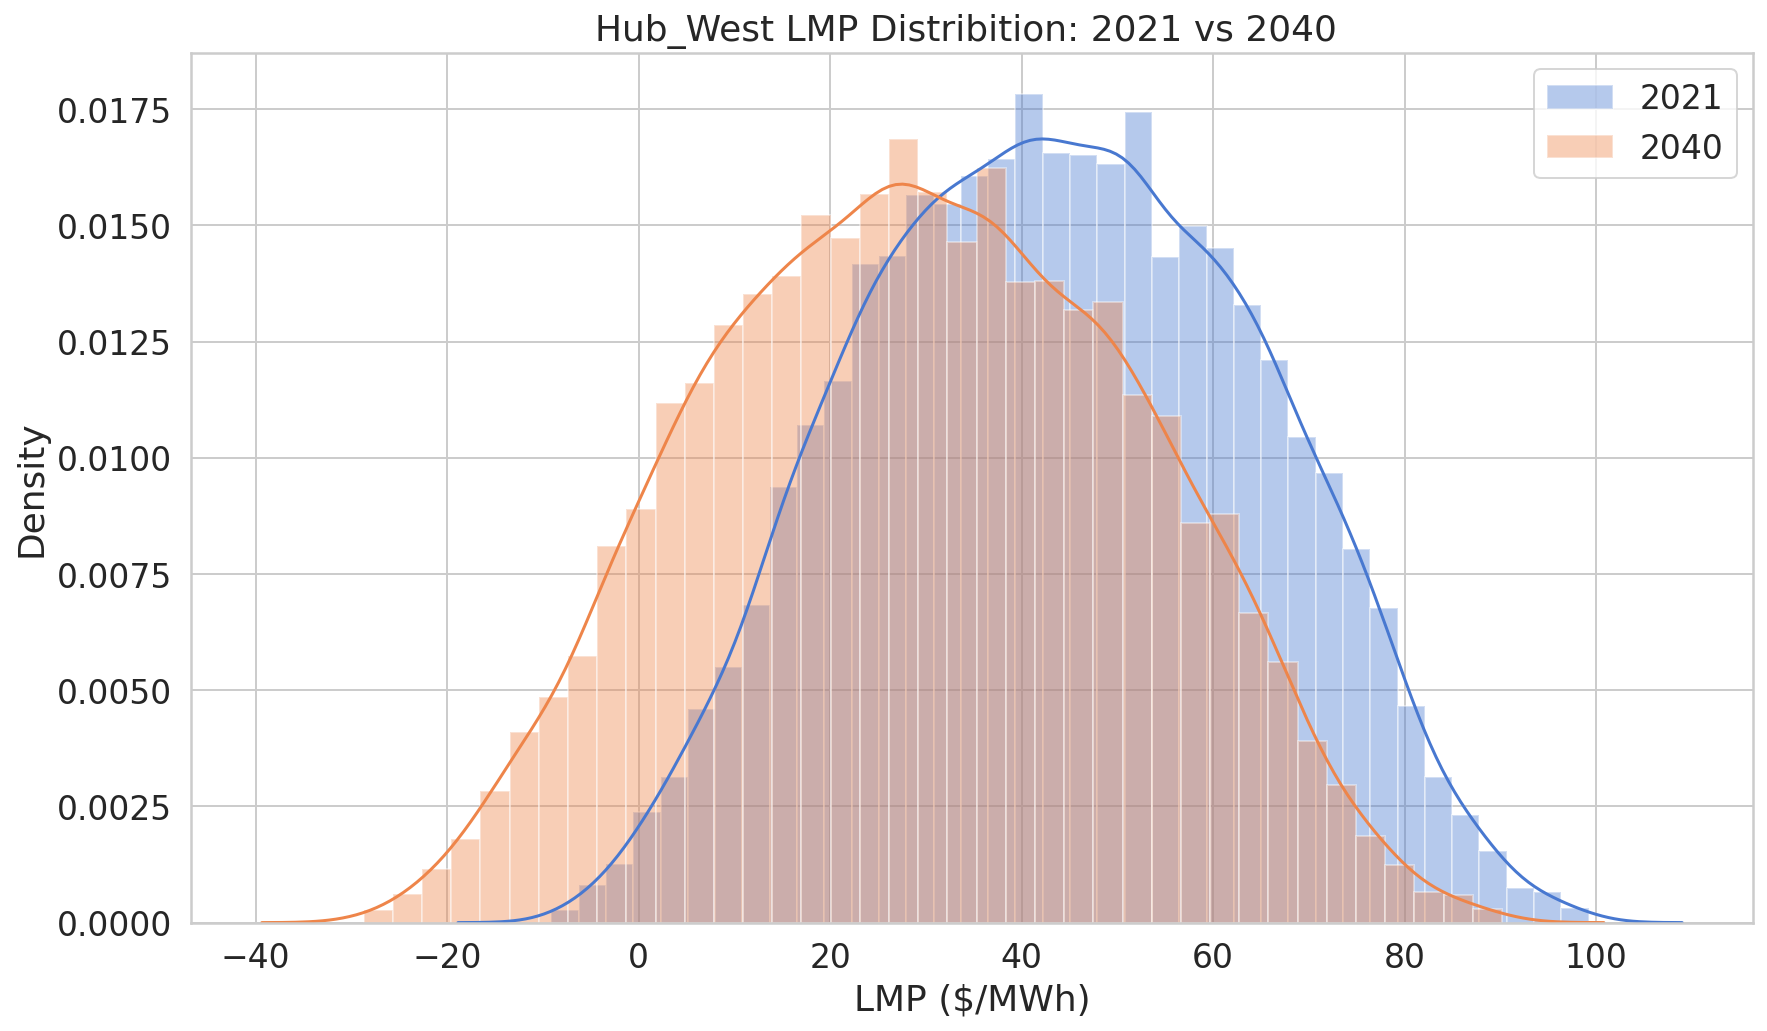

In [453]:
sns.distplot(reg_data_df.iloc[:,0],label="2021")
sns.distplot(reg_data_df.iloc[:,19],label="2040")
plt.title('Hub_West LMP Distribition: 2021 vs 2040 ')
plt.xlabel('LMP ($/MWh)')
plt.legend(loc="upper right")


In [441]:
reg_data_df.head()

Year,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040
0,38.205701,30.910803,34.711932,33.897755,33.523351,32.796726,33.774716,29.762341,28.700399,27.690200,26.823204,26.905383,25.930711,26.996865,27.388069,25.828636,25.159351,23.632694,23.793881,23.193887
1,71.524911,64.125208,68.165290,67.401681,66.941880,66.189537,67.312984,63.317499,62.505113,61.772827,61.078819,61.172704,60.211153,61.432159,61.937735,60.375497,59.711827,58.148562,58.274874,57.691280
2,37.910665,31.320422,34.889125,34.239206,34.001722,33.389072,34.469936,30.546129,29.553814,28.615065,27.729805,27.789269,26.714641,27.816327,28.229894,26.600550,25.841754,24.276887,24.427137,23.784401
3,76.060527,68.835148,73.031027,72.439073,72.179098,71.658243,72.869092,69.118303,68.404261,67.782507,67.203543,67.538740,66.689757,68.024035,68.667799,67.259444,66.790568,65.432011,65.723498,65.323416
4,23.098870,15.802612,19.433636,18.649529,18.167983,17.200161,18.088445,14.042869,13.006181,11.940878,10.937702,10.834310,9.671751,10.635185,10.958624,9.181118,8.380993,6.703460,6.725231,5.925152


In [447]:
age_sex = reg_data_df[["2021", "2022"]]

KeyError: "None of [Index(['2021', '2022'], dtype='object', name='Year')] are in the [columns]"

In [442]:
reg_data_df.columns

Int64Index([2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031,
            2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040],
           dtype='int64', name='Year')